![](https://i.imgur.com/eBRPvWB.png)

# Tłumaczenie typu Sequence 2 Sequence 


W tym projekcie nauczymy sieci neuronowej, aby przetłumaczyć z angielskiego na polski, przykłady jednak poniższe pokazują zasadę działania na przykładzie tłumaczenia z francuskiego na angielski.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```


... w różnym stopniu sukcesu.

Jest to możliwe dzięki prostej, ale mocnej idei [sekwencji do sekwencji sieci](http://arxiv.org/abs/1409.3215), w której dwie powtarzające się sieci neuronowe współpracują ze sobą, aby przekształcić jedną sekwencję w drugą. Sieć koderów skrapla sekwencję wejściową do pojedynczego wektora, a sieć dekodera rozwija ten wektor w nową sekwencję.

Aby ulepszyć ten model, użyjemy [mechanizmu uwagi](https://arxiv.org/abs/1409.0473), który pozwoli dekodowi nauczyć się skupiać na określonym zakresie sekwencji wejściowych.

# Model Sequence 2 Sequence


Sieć [Sequence to Sequence](http://arxiv.org/abs/1409.3215) lub seq2seq network lub [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), jest to model składający się z dwóch oddzielnych RNN zwanych **enkoderem** i **dekoderem**. Enkoder odczytuje sekwencję wejściową po jednym elemencie i wyprowadza wektor na każdym kroku. Końcowy wynik enkodera jest utrzymywany jako **kontekst**. Dekoder wykorzystuje ten wektor kontekstowy, aby wytworzyć sekwencję wyjść jeden krok na raz.

![](https://i.imgur.com/tVtHhNp.png)

Podczas korzystania z pojedynczego RNN istnieje relacja jeden do jednego pomiędzy wejściami i wyjściami. Szybko napotkaliśmy problemy z różnymi kolejnościami i długościami, które są częste podczas tłumaczenia. Rozważ proste zdanie "Je ne suis pas le chat noir" & rarr; "I am not the black cat" ("Nie jestem czarnym kotem"). Wiele słów ma całkiem bezpośrednie tłumaczenie, na przykład "chat" &rarr; "cat". Jednak różne gramatyki powodują, że słowa występują w różnych rzędach, np. "chat noir" &rarr; "black cat". Istnieje również "ne ... pas" &rarr; "not" konstrukcja, która sprawia, że dwa zdania mają różne długości.

W modelu seq2seq, kodując wiele wejść do jednego wektora i dekodując z jednego wektora na wiele wyjść, jesteśmy uwolnieni od ograniczeń kolejności i długości sekwencji. Zakodowana sekwencja jest reprezentowana przez pojedynczy wektor, pojedynczy punkt w N-wymiarowej przestrzeni sekwencji. W idealnym przypadku punkt ten można uznać za "znaczenie" sekwencji.

Ten pomysł może zostać przedłużony poza sekwencje. Zadania tworzenia napisów pobierają [obraz jako dane wejściowe i wypisują opis](https://arxiv.org/abs/1411.4555) obrazu (img2seq). Niektóre zadania generowania obrazów pobierają [opis jako dane wyjściowe i wygenerowany obraz](https://arxiv.org/abs/1511.02793) (seq2img). Modele te można ogólnie określić jako sieci "enkodera dekodera".

## Mechanizm Atencji

Wektor o stałej długości niesie ze sobą obciążenie kodowaniem całego "znaczenia" sekwencji wejściowej, bez względu na to, jak długo to trwa. Przy całej wariancji językowej jest to bardzo trudny problem. Wyobraź sobie dwa prawie identyczne zdania, dwadzieścia słów, z jednym tylko słowem innym. Zarówno enkodery, jak i dekodery muszą być wystarczająco zniuansowane, aby reprezentować tę zmianę jako bardzo nieznacznie inny punkt w przestrzeni.

Mechanizm **attention** [wprowadzony przez Bahdanau i innych](https://arxiv.org/abs/1409.0473) rozwiązuje ten problem, dając dekoderowi możliwość "zwrócenia uwagi" na części danych wejściowych, zamiast polegania na nich. na jednym wektorze. Dla każdego kroku dekoder może wybrać inną część zdania wejściowego do rozważenia.

![](https://i.imgur.com/5y6SCvU.png)

Atencja jest obliczana za pomocą kolejnej warstwy feedforward w dekoderze. Ta warstwa użyje bieżącego wejścia i stanu ukrytego, aby utworzyć nowy wektor, który ma taki sam rozmiar jak sekwencja wejściowa (w praktyce stała maksymalna długość). Wektor ten jest przetwarzany przez softmax, aby utworzyć *attention weights*, które są mnożone przez wyjścia enkoderów w celu utworzenia nowego wektora kontekstowego, który jest następnie wykorzystywany do przewidywania następnego wyniku.

![](https://i.imgur.com/K1qMPxs.png)



# Wymagania

Będziesz potrzebował [PyTorch](http://pytorch.org/), aby zbudować i wyszkolić modele, i [matplotlib](https://matplotlib.org/), aby wykreślić trenowanie i zwizualizować później wyniki atencji.

In [0]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
# %matplotlib inline

Tutaj również zdefiniujemy stałą, aby zdecydować, czy użyć GPU (w szczególności z CUDA), czy procesora. **Jeśli nie masz GPU, ustaw dla niego wartość `False`**. Później, kiedy stworzymy tensory, zmienna ta będzie używana do decydowania o tym, czy zachowamy je na procesorze, czy przeniesiemy na GPU.

In [0]:
USE_CUDA = True

# Ładowanie plików danych

Dane do tego projektu to zbiór wielu tysięcy par tłumaczeń z angielskiego na francuski.

[To pytanie na temat Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) skierowało mnie na stronę otwartego tłumaczenia http://tatoeba.org/ który ma pliki do pobrania dostępne na stronie http://tatoeba.org/eng/downloads - a jeszcze lepiej, ktoś wykonał dodatkową pracę polegającą na podzieleniu par językowych na poszczególne pliki tekstowe tutaj: http://www.manythings.org/anki/

Angielsko-francuskie pary są zbyt duże, by je uwzględnić w repozytorium, więc pobierz plik `fra-eng.zip`, wypakuj plik tekstowy i zmień jego nazwę na`data/eng-fra.txt` przed kontynuowaniem (z jakiegoś powodu plik zip nazywa się wstecz). Plik jest oddzielonymi tabulatorami parami tłumaczeń:

```
I am cold.    Je suis froid.
```

Podobnie jak w przypadku kodowania używanego w RNN na poziomie znaków, będziemy reprezentować każde słowo w języku jako wektor lub gigantyczny wektor zer, z wyjątkiem pojedynczego (w indeksie słowa). W porównaniu z dziesiątkami znaków, które mogą istnieć w języku, istnieje wiele wiele słów, więc wektor kodowania jest znacznie większy. Będziemy jednak trochę oszukiwać i trymować dane, aby używać tylko kilku tysięcy słów na język.

### Indeksowanie słów

Będziemy potrzebować unikalnego indeksu dla każdego słowa słowa, który później posłuży jako dane wejściowe i wyjściowe. Aby śledzić to wszystko, użyjemy klasy pomocniczej o nazwie `Lang`, która ma słowniki słowo &rarr; indeks (`word2index`) i indeks &rarr; słowo (`index2word`), a także licznik każdego słowa `word2count`, którego można użyć do późniejszego zastąpienia rzadkich słów.

In [0]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.index_word(word)

### Czytanie i dekodowanie plików

Wszystkie pliki są w Unicode, aby uprościć, zamienimy znaki Unicode na ASCII, zrobimy wszystko małymi literami i wycinamy większość znaków interpunkcyjnych.

In [0]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
# def unicode_to_ascii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
#     s = unicode_to_ascii(s.lower().strip())
    s = s.lower().strip()
    s = re.sub(r"([,.!?])", r" \1 ", s)
#     s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s
  
normalize_string('ala ma kota ąćęłńóśźż ĄĆĘŁŃÓŚŹŻ')

'ala ma kota ąćęłńóśźż ąćęłńóśźż'

Aby odczytać plik danych, podzielimy go na linie, a następnie podzielimy linie na pary. Wszystkie pliki są angielskie  &rarr; Inny język, więc jeśli chcemy przetłumaczyć z Innego języka &rarr; Angielski dodana została flaga `reverse`, aby odwrócić pary.

In [0]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
#     filename = '../data/%s-%s.txt' % (lang1, lang2)
    filename = 'data/seq2seq/%s-%s.txt' % (lang1, lang2)
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

Pełny proces przygotowywania danych to:

* Czytaj plik tekstowy i podziel na linie, 
* Podziel linie na pary i znormalizuj, 
* Filtruj według długości i zawartości
* Twórz listy słów ze zdań w parach



In [0]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %d sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
    
    print('Indexed %d words in input language, %d words in output' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'pol', False)

Reading lines...
Read 36856 sentence pairs
Filtered to 10021 pairs
Indexing words...
Indexed 3246 words in input language, 6104 words in output


### Filtrowanie zdań

Ponieważ istnieje *dużo* przykładowych zdań i chcemy szybko coś wytrenować, zmienimy zestaw danych tylko na względnie krótkie i proste zdania. Tutaj maksymalna długość to 10 słów (w tym interpunkcja), a my filtrujemy zdania, które tłumaczą się na formę "Jestem" (I am) lub "Jest" (He is) itd. (Z uwzględnieniem usuwania apostrofów).

In [0]:
MIN_COUNT = 3  # 5

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

keep_words 1278 / 3243 = 0.3941
keep_words 1532 / 6101 = 0.2511


### Filtrowanie par

Teraz wrócimy do zestawu wszystkich par zdań i usuniemy te z nieznanymi słowami.

In [0]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    
    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break

    for word in output_sentence.split(' '):
        if word not in output_lang.word2index:
            keep_output = False
            break

    # Remove if pair doesn't match input and output conditions
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from %d pairs to %d, %.4f of total" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs

Trimmed from 10021 pairs to 4830, 0.4820 of total


## Włączanie danych treningowych do Tensorów / Zmiennych

Aby trenować, musimy przekształcić zdania w coś, co sieć neuronowa może zrozumieć, co oczywiście oznacza liczby. Każde zdanie zostanie podzielone na słowa i przekształcone w Tensor, gdzie każde słowo zostanie zastąpione indeksem (z wcześniejszych indeksów Langa). Podczas tworzenia tych tensorów dodamy również token EOS, aby zasygnalizować, że zdanie jest skończone.

![](https://i.imgur.com/LzocpGH.png)

In [0]:
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

Możemy lepiej wykorzystać GPU, trenując wiele sekwencji naraz, ale czyniąc to, pojawia się pytanie, jak radzić sobie z sekwencjami o różnych długościach. Prostym rozwiązaniem jest "podkładanie" krótszych zdań z pewnym symbolem wypełnienia (w tym przypadku `0`) i ignorowanie tych wyściełanych miejsc podczas obliczania straty.

![](https://i.imgur.com/gGlkEEF.png)

In [0]:
# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

Aby utworzyć zmienną dla pełnej partii danych wejściowych (i wyjściowych), otrzymujemy losową próbkę sekwencji i przypisujemy je do długości najdłuższej sekwencji. Będziemy śledzić długości każdej partii, aby później ją usunąć.

Inicjowanie `LongTensor` za pomocą macierzy (partii) macierzy (sekwencji) daje nam tensor `(batch_size x max_len)` - wybór pierwszego wymiaru daje pojedynczą partię, która jest pełną sekwencją. Podczas szkolenia modelu będziemy potrzebować jednorazowego kroku naraz, więc przeniesiemy go do `(max_len x batch_size)`. Teraz wybieranie wzdłuż pierwszego wymiaru powoduje powrót do pojedynczego kroku w różnych partiach.


![](https://i.imgur.com/nBxTG3v.png)

In [0]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

Możemy przetestować to, aby zobaczyć, że zwróci on tensor `(max_len x batch_size)` dla zdań wejściowych i docelowych, wraz z odpowiadającą im listą długości partii dla każdego (które wykorzystamy później do maskowania).

In [0]:
random_batch(2)

(tensor([[  40,   68],
         [ 541,   24],
         [  29,    4],
         [   4,    2],
         [   2,    0]], device='cuda:0'), [5, 4], tensor([[  60,   11],
         [  26,   51],
         [ 570,    4],
         [   4,    2],
         [   2,    0]], device='cuda:0'), [5, 4])

# Budowanie modeli

## The Encoder

<img src="https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/images/encoder-network.png?raw=true" style="float: right" />

Enkoder pobiera serię sekwencji słów, `LongTensor` o rozmiarze `(max_len x batch_size)` i wyprowadza kodowanie dla każdego słowa,` FloatTensor` o rozmiarze `(max_len x batch_size x hidden_size)`.

Dane wejściowe są podawane przez [warstwę osadzającą `nn.Embedding`](http://pytorch.org/docs/nn.html#embedding) w celu utworzenia osadzania dla każdego słowa, z rozmiarem` seq_len x hidden_size` (jeśli to była partia słów). Zostało to zmienione na `seq_len x 1 x hidden_size`, aby pasowało do oczekiwanego wejścia [warstwy GRU` nn.GRU`](http://pytorch.org/docs/nn.html#gru). GRU zwróci zarówno sekwencję wyjściową o rozmiarze `seq_len x hidden_size`.



In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

## Dekoder Atencji

### Interpretacja modelu Bahdanau

Model atencji w [Neurowe tłumaczenie maszynowe przez wspólne uczenie się wyrównywania i tłumaczenia](https://arxiv.org/abs/1409.0473) jest opisany jako następująca seria równań:

Każde wyjście dekodera jest uwarunkowane poprzednimi wyjściami i pewnym $\mathbf x$, gdzie $\mathbf x $składa się z bieżącego stanu ukrytego (który bierze pod uwagę poprzednie wyjścia) i "kontekstu" uwagi, który jest obliczany poniżej. Funkcja $g$ jest w pełni połączoną warstwą z nieliniową aktywacją, która jako dane wejściowe przyjmuje połączone wartości $y_{i-1}$, $s_i$ i $c_i$.


$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

Bieżący stan ukryty $s_i$ jest obliczany przez RNN $f$ z ostatnim ukrytym stanem $s_{i-1}$, ostatnią wartością wyjściową dekodera $y_{i-1}$  i wektorem kontekstowym $c_i$.
W kodzie RNN będzie warstwą `nn.GRU`, ukryty stan $s_i$ będzie nazywany `hidden`, wyjście $y_i$ zwane `output` oraz kontekst $c_i$ zwany `context`.


$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

Wektor kontekstowy $c_i$ jest ważoną sumą wszystkich wyników enkodera, gdzie każda waga $a_{ij}$ jest ilością "atencji" przekazanej na odpowiednie wyjście enkodera $h_j$.


$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... gdzie każda waga $a_{ij}$ to znormalizowana (ponad wszystkie kroki) atencja "energia" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... gdzie każda energia atencji jest obliczana za pomocą funkcji $a$ (takiej jak inna warstwa liniowa) przy użyciu ostatniego ukrytego stanu $s_{i-1}$ i tego konkretnego wyjścia enkodera $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Interpretacja modelu Luong'a



[Skuteczne podejście do neuronowego tłumaczenia maszynowego z naciskiem na atencję](https://arxiv.org/abs/1508.04025) autorstwa Luonga i innych. opisuje kilka modeli atencji, które oferują ulepszenia i uproszczenia. Opisują kilka modeli "globalnej atencji", a rozróżnienie między nimi jest sposobem obliczania wyników atencji.

Ogólna forma obliczania atencji opiera się na ukrytym stanie po stronie docelowej (dekodera) i odpowiednim stanie bocznym źródła (enkodera), znormalizowanym dla wszystkich stanów, aby uzyskać wartości zsumowane do 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

Konkretną funkcją "wyniku" (score), która porównuje dwa stany, jest albo *dot* (kropka), prosty produkt punktowy między stanami; *general* (ogólnie), produkt kropki między ukrytym stanem dekodera a liniową transformacją stanu kodera; lub *concat*, produkt kropki między nowym parametrem $v_a$ a liniową transformacją stanów połączonych ze sobą.


$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

Modułowa definicja tych funkcji ewaluacji daje nam możliwość zbudowania specjalnego modułu atencji, który może przełączać się między różnymi metodami punktacji. Wejście do tego modułu jest zawsze stanem ukrytym (dekodera RNN) i zestawem wyjść enkodera.


### Implementacja modułu atencji

In [0]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        # return F.softmax(attn_energies).unsqueeze(1)
        return F.softmax(attn_energies, dim=-1).unsqueeze(1)
    
#     def score(self, hidden, encoder_output):
        
#         if self.method == 'dot':
#             energy = hidden.dot(encoder_output)
#             return energy
        
#         elif self.method == 'general':
#             energy = self.attn(encoder_output)
#             energy = hidden.dot(energy)
#             return energy
        
#         elif self.method == 'concat':
#             energy = self.attn(torch.cat((hidden, encoder_output), 1))
#             energy = self.v.dot(energy)
#             return energy

    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

### Implementacja modelu Bahdanau

Podsumowując, nasz dekoder powinien składać się z czterech głównych części - warstwy osadzającej, zamieniającej słowo wejściowe w wektor; warstwa do obliczenia energii uwagi na wyjście enkodera; warstwa RNN; i warstwę wyjściową.

Wejścia dekodera są ostatnim ukrytym stanem RNN $s_{i-1}$, ostatnie wyjście $y_{i-1}$ oraz wszystkie wyjścia enkodera $h_*$.

* warstwa osadzania z wejściami $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* warstwa atencji $a$ z wejściami $(s_{i-1}, h_j)$ i wyjściami $e_{ij}$, znormalizowanymi w celu utworzenia $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* wektor kontekstowy $c_i$ jako średnia ważona wyjść enkodera
    * `context = sum(attn_weights * encoder_outputs)`
* warstwa (warstwy) RNN $f$ z wejściami $(s_{i-1}, y_{i-1}, c_i)$ i wewnętrznym stanem ukrytym, wyprowadzanie $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* warstwa wyjściowa $g$ z wejściami $(y_{i-1}, s_i, c_i)$, wyprowadzanie $y_i$
    * `output = out(embedded, rnn_output, context)`



In [0]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        # output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        output = F.log_softmax(self.out(torch.cat((output, context), 1)), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

Teraz możemy zbudować dekoder, który podłącza ten moduł Attn za RNN, aby obliczyć wagi atencji, i zastosować te wagi do wyjść enkodera, aby uzyskać wektor kontekstu.


In [0]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

## Testowanie modeli

Aby upewnić się, że moduły enkodera i dekodera działają (i współpracują ze sobą), wykonamy pełny test przy pomocy małej partii.

In [0]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([6, 3])
target_batches torch.Size([7, 3])


Twórz modele o małym rozmiarze (można je kontrolować wzrokowo):

In [0]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(input_lang.n_words, small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, output_lang.n_words, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

Aby przetestować koder, przeprowadź wsad wejściowy, aby uzyskać poszczególne wyjścia kodera:

In [0]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([6, 3, 8])
encoder_hidden torch.Size([4, 3, 8])


Następnie zaczynając od tokena SOS, uruchamiaj tokeny słowne przez dekoder, aby uzyskać każdy następny token słowa. Zamiast robić to z całą sekwencją, robi się to po jednym na raz, aby wspierać używanie własnych przewidywań do wykonania następnej prognozy. Będzie to jednorazowy krok w danym momencie, ale w porcjach na czas. Aby to zadziałało w przypadku krótkich sekwencji, wielkość partii będzie się zmniejszać za każdym razem.

In [0]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths
)
# print('loss', loss.data[0])
print('loss', loss.item())

loss 7.458623886108398


# Trenowanie

## Definiowanie iteracji treningu

Aby ćwiczyć, najpierw uruchamiamy zdanie wejściowe za pomocą enkodera słowo po słowie i śledzimy każde wyjście i ostatni stan ukryty. Następnie dekoder otrzymuje ostatni ukryty stan dekodera jako swój pierwszy ukryty stan, a token "<SOS>" jako pierwsze wejście. Stąd przechodzimy do przepowiadania następnego tokena z dekodera.

### "Wymuszanie nauczycieli" i planowe pobieranie próbek

"Wymuszanie nauczycieli" lub pobieranie próbek o największej wiarygodności oznacza wykorzystanie rzeczywistych wyników docelowych jako każdego następnego wejścia podczas treningu. Alternatywą jest użycie własnego odgadnięcia przez dekoder jako następnego wejścia. Korzystanie z wymuszania nauczyciela może spowodować szybsze zbieganie się sieci, ale [kiedy wyszkolona sieć jest wykorzystywana, może wykazywać niestabilność](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

Możesz obserwować wyniki wymuszonych przez nauczyciela sieci, które czytają ze spójną gramatyką, ale oddalają się od prawidłowego tłumaczenia - możesz myśleć o tym, że nauczyłeś się słuchać instrukcji nauczyciela, nie ucząc się samodzielnego wyjścia.

Rozwiązanie problemu "wymuszania" nauczyciela jest znane jako [Zaplanowane próbkowanie](https://arxiv.org/abs/1506.03099), które po prostu przełącza się między wartościami docelowymi i przewidywanymi wartościami podczas trenowania. My losowo wybieramy użycie wymuszania nauczyciela instrukcją if podczas treningu - czasami będziemy podawać rzeczywisty cel jako wejście (ignorując wyjście dekodera), czasami użyjemy wyjścia dekodera.


In [0]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
#     ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
#     dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
#     return loss.data[0], ec, dc
    return loss.item(), ec, dc  

## Uruchamianie treningu

Gdy wszystko jest gotowe, możemy zainicjować sieć i rozpocząć trening.

Na początek uruchamiamy modele, optymalizatory i funkcję utraty (kryterium).

In [0]:
# Configure models
attn_model = 'dot'
hidden_size = 500
n_layers = 2
dropout = 0.1
batch_size = 50 # 1600  # 100
# batch_size = 50

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 1000 # 50000
epoch = 0
plot_every = 10
print_every = 50  # 100
evaluate_every = 50 # 1000

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

In [0]:
from torchnet.logger import VisdomPlotLogger, VisdomLogger, VisdomTextLogger
from tqdm import tqdm
import io
import json

# Start a job

class Job:
    def __init__(self, name, params={}, hostname='localhost', port=8890, n_epochs=10):
        self.name = name
        self.params = params
        self.hostname = hostname
        self.port = port
        self.avg_train_loss_logger = VisdomPlotLogger(
        'line', port=port, opts={'title': f'{name}_Train Loss'})
        self.job_logger = VisdomTextLogger(port=port, opts={'title': f'{name}_Job Info'})
        self.log_logger = VisdomTextLogger(port=port, opts={'title': f'{name}_Train Loss Log'}, update_type='APPEND')
        self.pbar = tqdm(total=n_epochs, ncols=60, mininterval=1.0, ascii=True, file=io.StringIO())
        self.progress_logger = VisdomTextLogger(port=port, opts=dict(title=f'{name}_Progress Bar',
            width=500,
            height=50,
        ))

        self.start()

    def start(self):
#         j = {'name': self.name, 'params': self.params, 'hostname': self.hostname}
        j_str = json.dumps(self.params, indent=4)
        j_str = j_str.replace('\n', '<br/>\n').replace(' ', '&nbsp;')
        self.job_logger.log(f'{j_str}')

        self.job_id = '#job_id'# body['id']
        print("Starting job %s at %s" % (self.job_id, time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())))
        self.start_time = time.time()

        self.log_every = 50
        self.plot_every = 50
        self.loss_avg = 0

    def stop(self, ):
        j = {'status': 'done'}
        print(j)

    def log(self, l):
        def time_since(since):
            now = time.time()
            s = now - since
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)
        # print('[log] %s' % time_since(self.start_time), l)
        self.log_logger.log(l)

    def plot(self, x, y):
        # print(f'[plot] ({x}, {y})')
        self.avg_train_loss_logger.log(x, y)

    def record(self, e, loss):
        self.loss_avg += loss

        if e > 0 and e % self.log_every == 0:
            self.log('(%s) %.4f' % (e, loss))

        if e > 0 and e % self.plot_every == 0:
            self.plot(e, self.loss_avg / self.plot_every)
            self.loss_avg = 0

    def update_progress(self, ):
        self.pbar.update(1)
        text = f'{self.pbar}'.replace(' ', '<font color="white">#</font>')
        self.progress_logger.log(text)

In [0]:
# import sconce
# job = sconce.Job('seq2seq-translate', {
job = Job('seq2seq-translate', {
    'attn_model': attn_model,
    'n_layers': n_layers,
    'dropout': dropout,
    'hidden_size': hidden_size,
    'learning_rate': learning_rate,
    'clip': clip,
    'teacher_forcing_ratio': teacher_forcing_ratio,
    'decoder_learning_ratio': decoder_learning_ratio,
}, n_epochs=n_epochs)
job.plot_every = plot_every
job.log_every = print_every

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

import visdom

vis = visdom.Visdom(port=job.port)

Starting job #job_id at 2018-05-07 12:00:18


In [0]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

# Ewaluacja sieci

Ewaluacja jest w większości taka sama jak w przypadku treningu, ale nie ma żadnych wyników. Zamiast tego zawsze podajemy prognozy dekodera z powrotem do siebie. Za każdym razem, gdy przewiduje słowo, dodajemy je do ciągu wyjściowego. Jeśli przewiduje to token EOS, zatrzymujemy się tam. Przechowujemy także wyniki uwagi dekodera dla każdego kroku, aby wyświetlić później.


In [0]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    # https://github.com/spro/practical-pytorch/issues/95
    # input_lengths = [len(input_seq)]
    
    # UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
    # https://discuss.pytorch.org/t/torch-no-grad/12296
    
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_lengths = [len(input_seqs[0])]

    # input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)

    if USE_CUDA:
        input_batches = input_batches.cuda()

    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)

    # Run through encoder
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    # decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)

    # Run through decoder
    for di in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])

        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


Możemy oceniać losowe zdania z zestawu treningowego i drukować dane wejściowe, docelowe i wyjściowe w celu dokonania subiektywnej oceny jakości:

In [0]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

# Wizualizacja atencji

Użyteczną właściwością mechanizmu atencji są jego wysoce interpretowalne wyniki. Ponieważ jest on używany do ważenia określonych wyjść kodera sekwencji wejściowej, możemy sobie wyobrazić, gdzie najlepiej jest skupić się w sieci na każdym kroku.

Możesz po prostu uruchomić `plt.matshow(attentions)`, aby zobaczyć wyniki atencji wyświetlane jako matryca, z kolumnami będącymi krokami wejściowymi i wierszami będącymi krokami wyjściowymi:

In [0]:
import io
import torchvision
from PIL import Image

Aby uzyskać lepsze wrażenia wizualne, wykonamy dodatkową pracę dodawania osi i etykiet:

In [0]:
def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

In [0]:
def show_attention(input_sentence, output_words, attentions):
    mpl.style.use('default')
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)    
    cax = ax.matshow(attentions.numpy(), cmap='jet') # cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

In [0]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    vis.text(text, win=win, opts={'title': win})

#Kładąc wszystko razem

**TODO** Uruchamia `train_epochs` dla `n_epochs`

Żeby przeprowadziwy właściwy trening, wielokrotnie wywołujemy funkcję treningową.


/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|#                    | 50/1000 [02:28<37:59,  2.40s/it]
2m 28s (- 46m 57s) (50 5%) 4.4833
> hey , thanks a lot .
= hej , wielkie dzięki .
< nie nie nie . <EOS>


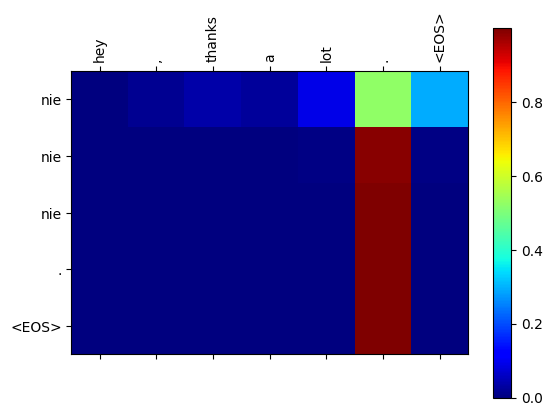

 10%|##                  | 100/1000 [04:30<38:09,  2.54s/it]
4m 30s (- 40m 34s) (100 10%) 3.5696
> i don't quite know yet .
= jeszcze nie bardzo wiem .
< nie nie nie nie nie nie nie . <EOS>


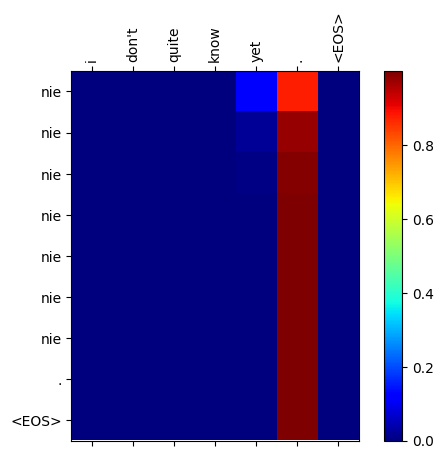

 15%|###                 | 150/1000 [06:31<35:54,  2.54s/it]
6m 31s (- 37m 0s) (150 15%) 3.1662
> what will you do ?
= co pan zrobi ?
< co co pan ? <EOS>


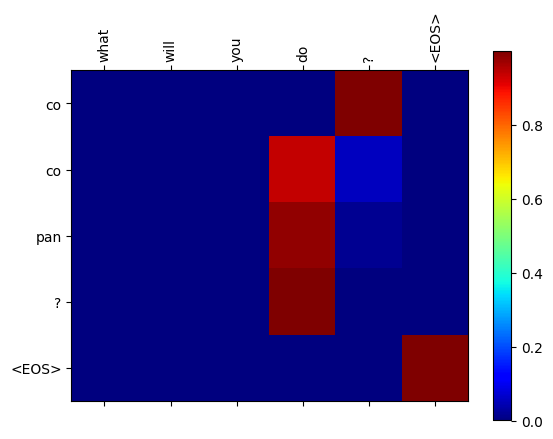

In [0]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    
    job.record(epoch, loss)
    job.update_progress()

    if epoch % print_every == 0:
        print(f'{job.pbar}')
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

## Wyrysowywanie strat treningowych

Wykreślanie odbywa się za pomocą matplotlib, przy użyciu macierzy `plot_losses`, która została utworzona podczas treningu.


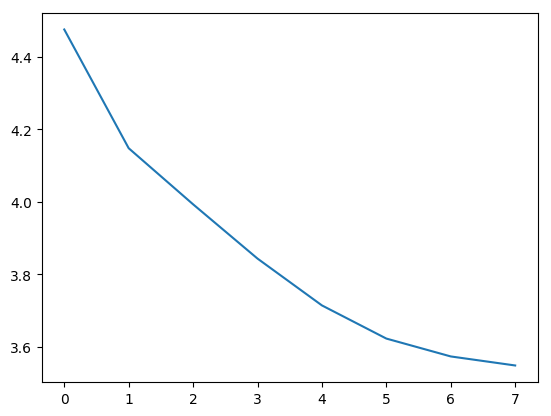

In [0]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [0]:
xxx=[print(random.choice(pairs)) for i in range(10)]

['it was horrible .', 'to było straszne .']
["you're a woman .", 'jesteś kobietą .']
['tom walked home .', 'tom przyszedł do domu .']
['i just want to help .', 'po prostu chcę pomóc .']
['take over .', 'przejąć .']
["no , i didn't go .", 'nie , nie poszedłem .']
['who is that boy ?', 'kim jest ten chłopak ?']
["i'm very sorry .", 'jest mi bardzo przykro .']
['i love this game .', 'uwielbiam tę grę .']
['i really want to leave .', 'naprawdę chcę wyjść .']


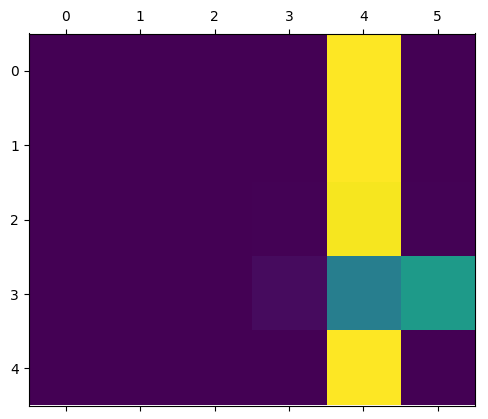

In [0]:
output_words, attentions = evaluate("it's time for lunch .")
plt.matshow(attentions.numpy())
show_plot_visdom()

['i failed after all .', 'nie udało mi się jednak .']
['i like you very much .', 'bardzo cię lubię .']
["i can't leave .", 'nie mogę wyjść .']
['i feel very good .', 'czuję się bardzo dobrze .']
["we've been here an hour .", 'jesteśmy tutaj godzinę .']
["i don't like it .", 'nie lubię tego .']
['tom likes boston .', 'tom lubi boston .']
['that works .', 'to działa .']
['i will try it again .', 'spróbuję ponownie .']
['tom drank some beer .', 'tom wypił piwo .']

> i failed after all .
= nie udało mi się jednak .
< nie nie nie dużo . <EOS>


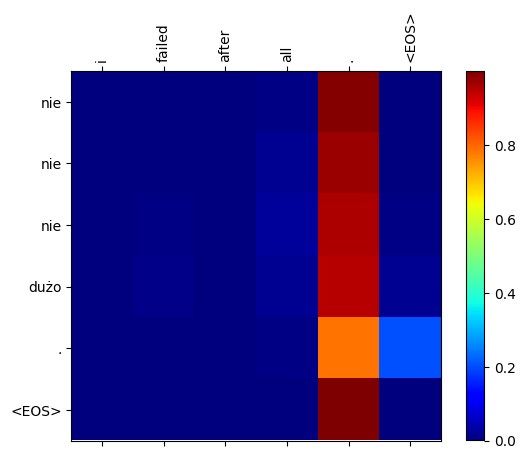

In [0]:
evaluate_and_show_attention('i failed after all .', 'nie udało mi się jednak .')

> i like you very much .
= bardzo cię lubię .
< nie nie nie nie w . <EOS>


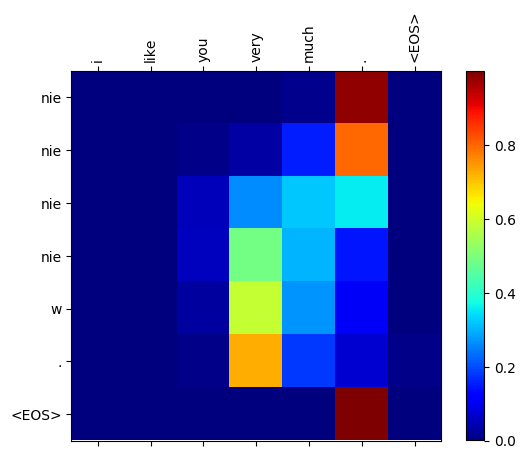

In [0]:
evaluate_and_show_attention('i like you very much .', 'bardzo cię lubię .')

> i can't leave .
= nie mogę wyjść .
< nie mogę wyjść . <EOS>


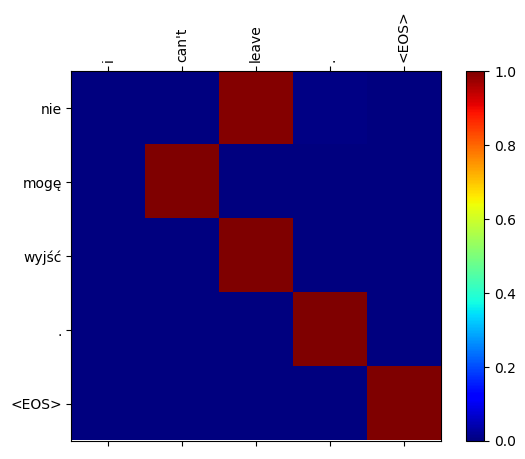

In [0]:
evaluate_and_show_attention("i can't leave .", 'nie mogę wyjść .')

> i feel very good .
= czuję się bardzo dobrze .
< czuję się bardzo dobrze . <EOS>


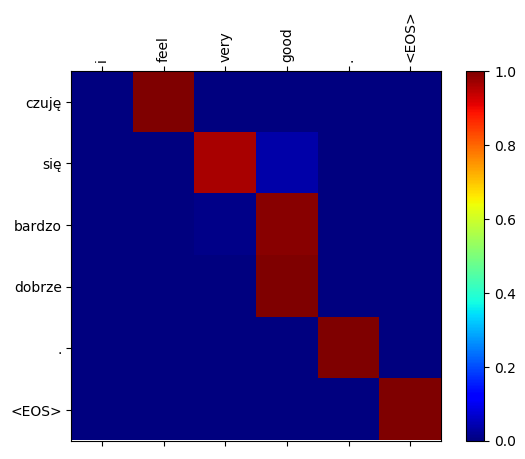

In [0]:
evaluate_and_show_attention('i feel very good .', 'czuję się bardzo dobrze .')

> we've been here an hour .
= jesteśmy tutaj godzinę .
< jesteśmy tutaj godzinę . <EOS>


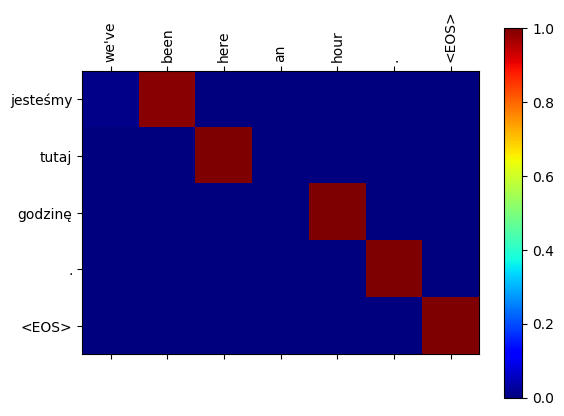

In [0]:
evaluate_and_show_attention("we've been here an hour .", 'jesteśmy tutaj godzinę .')

> i don't like it .
= nie lubię tego .
< to mi się nie podoba . <EOS>


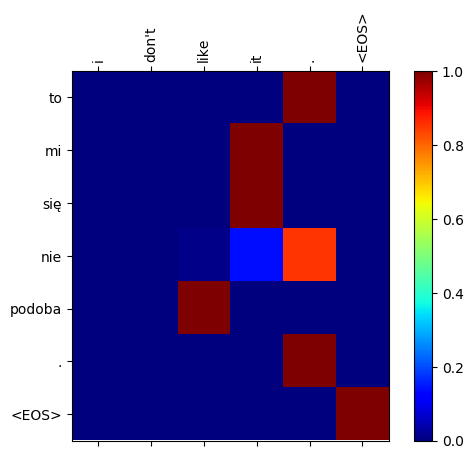

In [0]:
evaluate_and_show_attention("i don't like it .", 'nie lubię tego .')

# Ćwiczenia

* Spróbuj użyć innego zestawu danych
     * Kolejna para językowa
     * Człowiek &rarr; Maszyna (np. Komendy IOT)
     * Czat &rarr; Odpowiedź
     * Pytanie &rarr; Odpowiedź
* Zastąp osadzone wcześniej słowa, takie jak word2vec lub GloVe
* Wypróbuj więcej warstw, więcej ukrytych jednostek i więcej zdań. Porównaj czas trenowania i wyniki.
* Jeśli używasz pliku tłumaczenia, w którym pary mają dwie takie same frazy (`I am test \t I am test`), możesz użyć tego jako automatycznego enkodera. Spróbuj tego:
     * Trenuj jako autoencoder
     * Zapisz tylko sieć Encoder
     * Wytrenuj nowy Dekoder do tłumaczenia z tego miejsca
